# WeatherPy

---

In [1]:
# load dependencies
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress

# citipy will help determine cities based on latitude and longitude data
from citipy import citipy

# import OpenWeatherMap API key
from api_keys import weather_api_key

### Generate the Cities List by Using the `citipy` Library

In [2]:
# instantiate an empty list for holding lat/lng combinations, and one for holding nearest city names
lat_lngs = []
cities = []

# set a range of latitudes and longitudes for random generation
lat_range = (-90, 90)
lng_range = (-180, 180)

# create a set of 1500 random lat/lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)
lat_lngs

In [3]:
# identify the nearest city for each lat/lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # only add new cities to our list
    if city not in cities:
        cities.append(city)

# print the city count
print(f"Number of cities in the list: {len(cities)}")

Number of cities in the list: 599


### Showcase the Relationship Between Weather Attributes and Latitude

In [4]:
# retrieve weather attributes for relevant cities
api_url = 'https://api.openweathermap.org/data/2.5/weather?lat={lat}&lon={lng}&appid={API_key}'
city_weather_data = {}

for i, city in enumerate(cities):

    if i % 100 == 0 and i > 1:
        print(f'Working on city #{i}.\n-----\n')

    try:
        response = requests.get(api_url.format(lat=lats[i], lng=lngs[i], API_key=weather_api_key))
        data = response.json()
        
        city_weather_data[city] = {'City' : city,
                                   # 'Country' : data['sys']['country'],
                                   'Latitude' : data['coord']['lat'],
                                   'Longitude': data['coord']['lon'],
                                   'Temperature (Max)' : data['main']['temp_max'],
                                   'Humidity' : data['main']['humidity'],
                                   'Cloudiness' : data['clouds']['all'],
                                   'Wind Speed' : data['wind']['speed']}
        
    except:
        print(f'{city.title()} not found. Moving on.\n-----\n')

print('\nData retrieval complete.\n-----\n')
    


Working on city #100.
-----

Working on city #200.
-----

Working on city #300.
-----

Working on city #400.
-----

Working on city #500.
-----



In [ ]:
# convert the dictionary to a `pandas` data frame and examine data types
city_weather_df = pd.DataFrame.from_dict(city_weather_data, orient='index').reset_index(drop=True)
city_weather_df.dtypes

City                  object
Latitude             float64
Longitude            float64
Temperature (Max)    float64
Humidity               int64
Cloudiness             int64
Wind Speed           float64
dtype: object

In [ ]:
# write to csv
city_weather_df.to_csv('output_data/city_weather.csv')
# visualize the the data frame
city_weather_df

,City,Latitude,Longitude,Temperature (Max),Humidity,Cloudiness,Wind Speed
0,comodoro rivadavia,-47.6686,-68.0335,282.05,30,6,5.90
1,lebu,-33.9337,-93.5443,291.91,71,8,5.55
2,illoqqortoormiut,85.6955,-27.8377,246.09,96,37,3.17
3,sitka,50.1235,-136.7123,276.62,97,100,11.54
4,albany,-53.4950,115.5237,276.00,78,100,13.00
...,...,...,...,...,...,...,...
593,tawang,-68.9770,-123.3638,265.71,93,84,4.72
594,lebanon,-34.5370,-71.1383,292.95,50,100,1.82
595,carauari,-70.2726,71.2823,248.99,77,17,9.59
596,gua musang,-72.6518,106.1742,227.40,100,74,5.82


#### Latitude vs. Attribute Scatter Plots

We can use the data from OpenWeatherMap to visulize relationaships between city latitudes and several key weather attributes provided through the API. This should help provide us with some intuition as to how changes in latitude might affect weather patterns.

* Latitude vs. Temperature
* Latitude vs. Humidity
* Latitude vs. Cloudiness
* Latitude vs. Wind Speed

/var/folders/m6/5m5yr4vx1hnfwqqw70nydyqr0000gn/T/ipykernel_37427/599901598.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


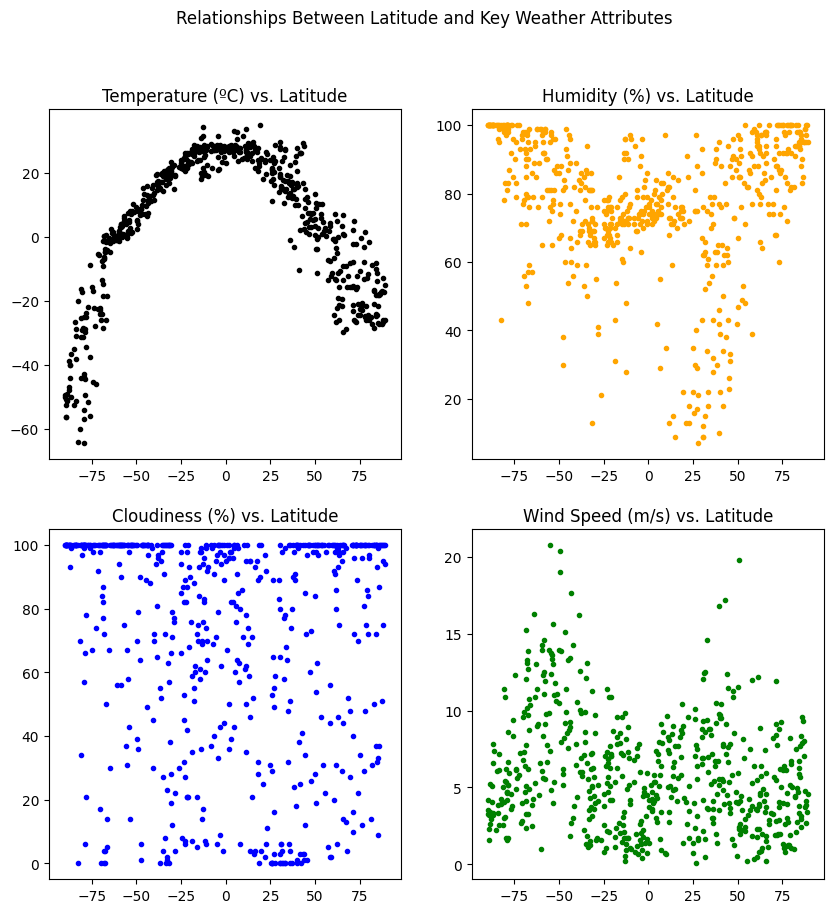

In [ ]:
# display a latitude vs. temperature scatter plot
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle('Relationships Between Latitude and Key Weather Attributes')
axs[0, 0].scatter(city_weather_df['Latitude'], city_weather_df['Temperature (Max)'] - 273.15, c='black', marker='.')
axs[0, 0].set_title('Temperature (ºC) vs. Latitude')
axs[0, 1].scatter(city_weather_df['Latitude'], city_weather_df['Humidity'], c='orange', marker='.')
axs[0, 1].set_title('Humidity (%) vs. Latitude')
axs[1, 0].scatter(city_weather_df['Latitude'], city_weather_df['Cloudiness'], c='blue', marker='.')
axs[1, 0].set_title('Cloudiness (%) vs. Latitude')
axs[1, 1].scatter(city_weather_df['Latitude'], city_weather_df['Wind Speed'], c='green', marker='.')
axs[1, 1].set_title('Wind Speed (m/s) vs. Latitude')

# save and display
fig.savefig("output_data/ScatterPlotFigure.png")
fig.show()

### Apply Linear Regression to Each Relationship

In [ ]:
# define a function that splits the data into Northern and Southern hemispheres and computes linear regression
def HemiRegress(lat, att):

    # create a dataframe, then split into Northern and Southern hemispheres
    full_df = pd.DataFrame({'Latitude' : lat, 'Attribute' : att})
    northern_df = full_df.loc[full_df['Latitude'] >= 0]
    southern_df = full_df.loc[full_df['Latitude'] < 0]

    # raise an exception if there is a concern about mismatched data subset sizes
    if len(northern_df) + len(southern_df) != len(full_df):
        raise Exception('Uh oh! Something went wrong splitting your data.')
    
    # perform regressions
    northern_reg = linregress(northern_df['Latitude'], northern_df['Attribute'])
    southern_reg = linregress(southern_df['Latitude'], southern_df['Attribute'])

    # create model arrays for plotting northern hemisphere regression
    northern_x = np.linspace(0, 90, 100)
    northern_y = northern_reg[0] * northern_x + northern_reg[1]

    # create model arrays for plotting southern hemisphere regression
    southern_x = np.linspace(-90, 0, 100)
    southern_y = southern_reg[0] * southern_x + southern_reg[1]

    # create a split plot
    fig, axs = plt.subplots(1, 2, figsize=(13, 5))
    fig.suptitle(f'{att.name} vs. Latitude Split by Hemisphere')

    axs[0].scatter(northern_df['Latitude'], northern_df['Attribute'], c='blue', marker='.')
    axs[0].plot(northern_x, northern_y, c='red')
    axs[0].set_title('Northern Hemisphere')
    axs[0].set_ylabel(f'{att.name}')
    axs[0].set_xlabel(f'y = {round(northern_reg[0], 2)}x + {round(northern_reg[1], 2)}\nr = {round(northern_reg[2], 5)}', c='r')

    axs[1].scatter(southern_df['Latitude'], southern_df['Attribute'], c='green', marker='.')
    axs[1].plot(southern_x, southern_y, c='red')
    axs[1].set_title('Southern Hemisphere')
    axs[1].set_ylabel(f'{att.name}')
    axs[1].set_xlabel(f'y = {round(southern_reg[0], 2)}x + {round(southern_reg[1], 2)}\nr = {round(southern_reg[2], 5)}', c='r')

    # save and display
    fig.savefig(f'output_data/{att.name}_Regressions.png'.replace(' ', '_'))
    fig

    return

##### Temperature Regression

/var/folders/m6/5m5yr4vx1hnfwqqw70nydyqr0000gn/T/ipykernel_37427/812283131.py:43: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


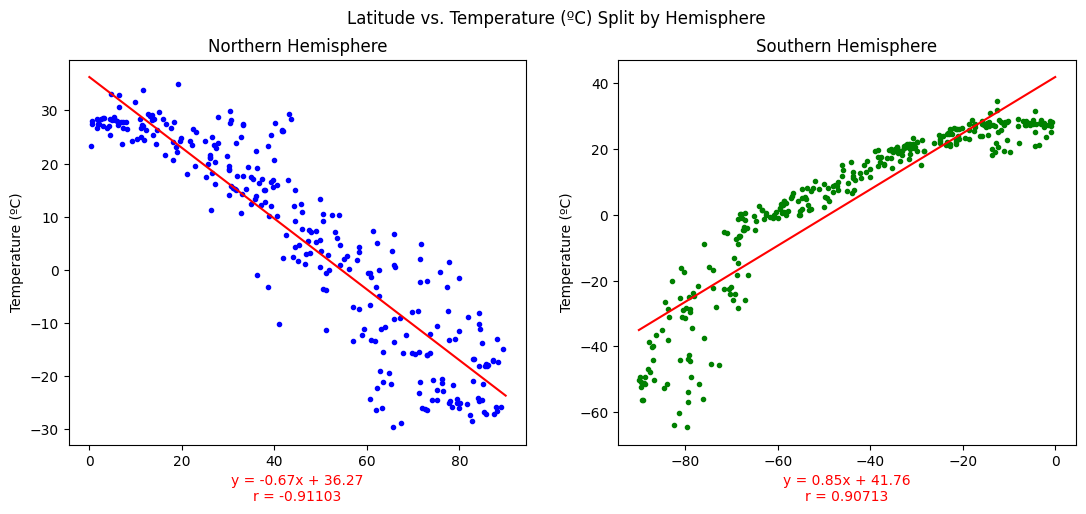

In [ ]:
# call our splitting and regression function with the temperature attribute
HemiRegress(city_weather_df['Latitude'], city_weather_df['Temperature (Max)'].rename('Temperature (ºC)') - 273.15)

##### Humidity Regression

/var/folders/m6/5m5yr4vx1hnfwqqw70nydyqr0000gn/T/ipykernel_37427/812283131.py:43: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


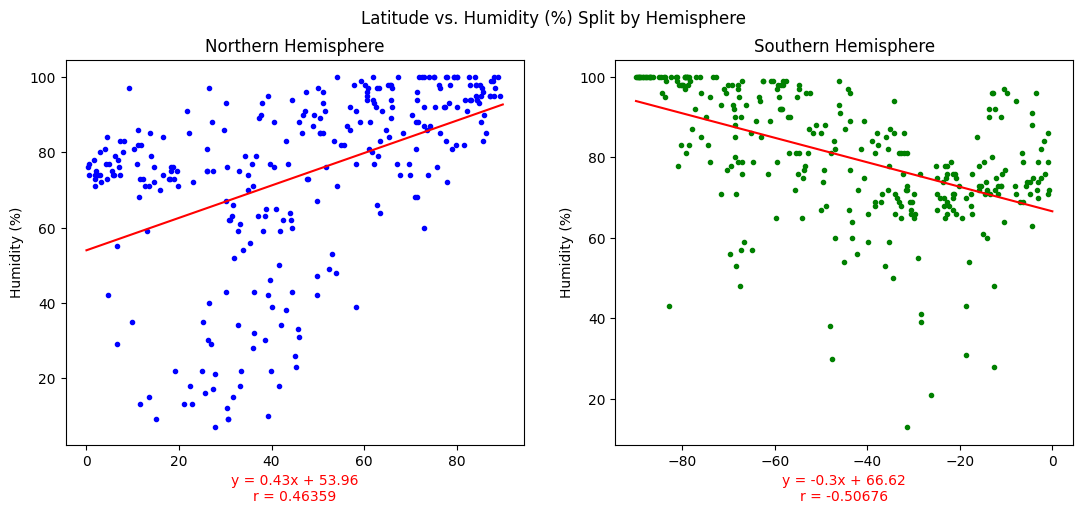

In [ ]:
# call our splitting and regression function with the humidity attribute
HemiRegress(city_weather_df['Latitude'], city_weather_df['Humidity'].rename('Humidity (%)'))

##### Cloudiness Regression

/var/folders/m6/5m5yr4vx1hnfwqqw70nydyqr0000gn/T/ipykernel_37427/812283131.py:43: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


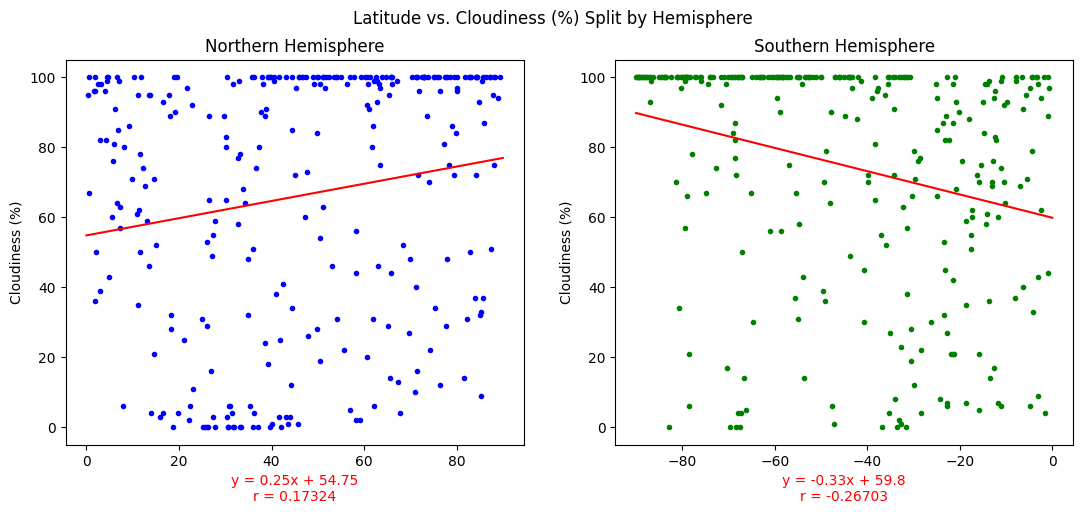

In [ ]:
# call our splitting and regression function with the cloudiness attribute
HemiRegress(city_weather_df['Latitude'], city_weather_df['Cloudiness'].rename('Cloudiness (%)'))

##### Wind Speed Regression

/var/folders/m6/5m5yr4vx1hnfwqqw70nydyqr0000gn/T/ipykernel_37427/812283131.py:43: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


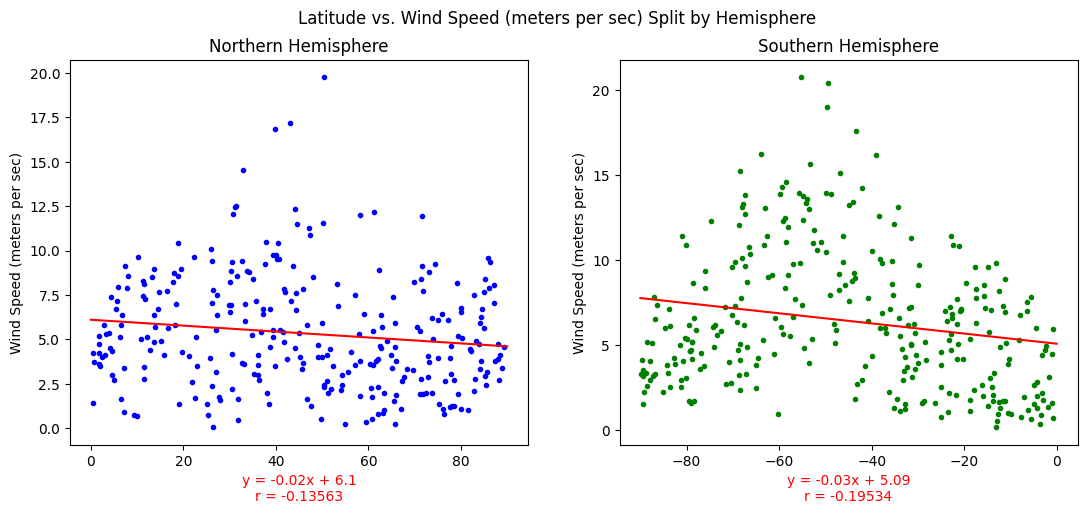

In [ ]:
# call our splitting and regression function with the cloudiness attribute
HemiRegress(city_weather_df['Latitude'], city_weather_df['Wind Speed'].rename('Wind Speed (meters per sec)'))